In [1]:
import numpy as np
import matplotlib.pyplot as plt


import torch
from torch import nn

from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [2]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15253100.37it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 455371.67it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3669980.67it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1905433.96it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



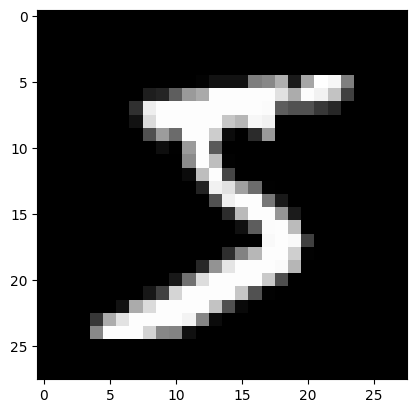

In [3]:
img = train_data[0][0] 
img = img.view(28,28)
plt.imshow(img, cmap='gray')

In [4]:
def get_data(data, noise_rate=0.1):
    all_imgs = [] 
    all_noise_imgs = [] 
    for img in data:
        img = img[0] 
        noise_img = img + torch.randn(28,28) * noise_rate 
        noise_img = torch.clip(noise_img, 0.0, 1.0 )
        
        all_imgs.append(img) 
        all_noise_imgs.append(noise_img) 
        
    return all_imgs, all_noise_imgs
        

In [5]:
train_input , train_target = get_data(train_data)

In [6]:
test_input, test_target = get_data(test_data)

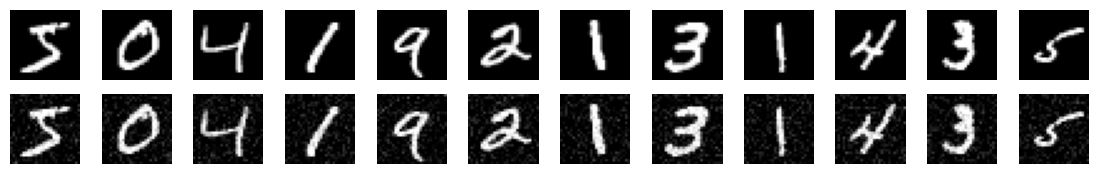

In [7]:
plt.figure(figsize=(14,2)) 
rows = 2
cols = 12

for i in range(cols):
    plt.subplot(rows, cols, i+1) 
    plt.imshow(train_input[i].view(28,28), cmap='gray') 
    plt.axis('off')
    plt.subplot(rows, cols, i+1+cols) 
    plt.imshow(train_target[i].view(28,28), cmap='gray') 
    plt.axis('off')

In [8]:
class MyDataset(Dataset):
    def __init__(self, train_inp, train_target):
        self.train_inp = train_inp
        self.train_target = train_target
        
    def __len__(self):
        return len(self.train_inp) 
    
    def __getitem__(self, index):
        return  self.train_target[index] , self.train_inp[index]
    

    
train_ds = MyDataset(train_input, train_target)
test_ds = MyDataset(test_input, test_target) 

train_dl = DataLoader(train_ds, batch_size = 32, shuffle=True) 
test_dl = DataLoader(test_ds, batch_size= 32) 




In [9]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.relu_1 = nn.ReLU() 
        self.pool1 = nn.MaxPool2d(kernel_size=2, padding=1) 
        self.conv_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1) 
        self.relu_2 = nn.ReLU() 
        self.pool2 = nn.MaxPool2d(kernel_size=2, padding=1) 
        
        self.conv_trans_1 = nn.ConvTranspose2d(32, 32, stride=2, kernel_size=3, padding=1) 
        self.relu_3 = nn.ReLU() 
        self.conv_trans_2 = nn.ConvTranspose2d(32,32 , kernel_size=2, stride=2, padding=1) 
        self.relu_4 = nn.ReLU() 
        self.conv_3 = nn.Conv2d(32,1, kernel_size=3, padding=1) 
        self.sigmoid = nn.Sigmoid() 
        
    def forward(self, data):
        x = self.conv_1(data) 
        x = self.relu_1(x) 
        x = self.pool1(x) 
        x = self.conv_2(x) 
        x = self.relu_2(x) 
        x = self.pool2(x) 
        x = self.conv_trans_1(x) 
        x = self.relu_3(x) 
        x = self.conv_trans_2(x) 
        x = self.relu_4(x) 
        x = self.conv_3(x) 
        x = self.sigmoid(x) 
        
        return x

In [16]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        
        # Decoder
        self.deconv1 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1,)
        self.relu3 = nn.ReLU()
        self.deconv2 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=1, )
        self.relu4 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = self.relu1(self.conv1(x))
        x = self.pool(x)
        x = self.relu2(self.conv2(x))
        x = self.pool(x)
        
        # Decoder
        x = self.relu3(self.deconv1(x))
        x = self.relu4(self.deconv2(x))
        x = torch.sigmoid(self.conv3(x))

        return x

# Instantiate the model
autoencoder = Autoencoder()

# Compile the model
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.BCELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
autoencoder = autoencoder.to(device)

In [11]:
# loss_fn = nn.BCELoss()
# optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3) 

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
# model = MyModel()
# model = model.to(device)

In [31]:
batch_size = 32
def train_model(model, data, loss_fn, optim, epochs=5):
    model.train() 
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1} :---------------------------------")
        for batch , (X,y) in enumerate(data):
            X = X.to(device) 
            y = y.to(device) 
            
            preds = model(X) 
            loss = loss_fn(preds, y) 
            
            loss.backward() 
            optim.step() 
            optim.zero_grad() 
            
            
            if batch % 500 ==0:
                current = batch * batch_size + len(y) 
                
                print(f"Loss : {loss.item():.3f} | current : [{current:<3d}/{len(data.dataset)}]")
                
         
    

def test_model(model, data, loss_fn):
    model.eval() 
    
    test_loss =0
    correct = 0 
    num_batches = len(data) 
    size = len(data.dataset)
    
    with torch.no_grad():
        for X,y in data:
            X = X.to(device) 
            y = y.to(device) 
            
            pred = model(X) 
            test_loss += loss_fn(pred, y).item() 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() 
            
    test_loss /= num_batches 
    correct /= (size * 1*28*28)
    
    print(f'Test Error: \n Accuracy {(100*correct):>0.1f}%, Avg Loss : {test_loss:>8f} \n') 
    
            
                

In [32]:
test_model(autoencoder, test_dl, criterion)

Test Error: 
 Accuracy 2581.2%, Avg Loss : 0.067030 



In [ ]:
test_model(autoencoder, train_dl, criterion, optimizer, epochs=3)

In [20]:
inp = torch.stack(test_target, dim=0) 
print(inp.shape)

torch.Size([10000, 1, 28, 28])


In [21]:
y = autoencoder(inp)

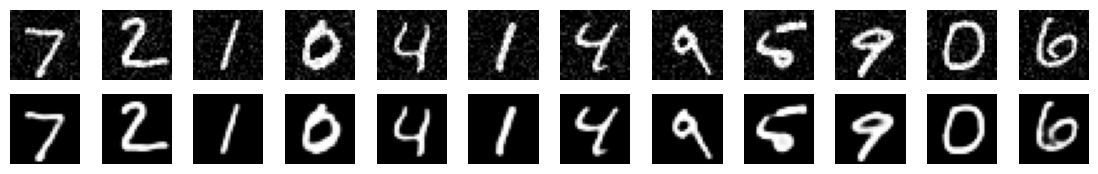

In [22]:
plt.figure(figsize=(14,2)) 
rows = 2
cols = 12

for i in range(cols):
    plt.subplot(rows, cols, i+1) 
    plt.imshow(inp[i].view(28,28), cmap='gray') 
    plt.axis('off')
    plt.subplot(rows, cols, i+1+cols) 
    plt.imshow(y[i].detach().numpy().reshape((28,28)), cmap='gray') 
    plt.axis('off')